In [1]:
import pandas as pd
from pylab import plt, mpl
import numpy as np
import yfinance as yf
import requests
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

# Fetch and Wrangle Data

Create a Function that retrives and returns End of Day Financial Data and subsequently creates short and Long term averages

In [66]:
def fetch_data(ticker):
    tick = yf.Ticker(ticker)
    data = tick.history('5y')
    data = data[['Close']]
    data['SMA'] = data['Close'].rolling(42).mean()
    data['LMA'] = data['Close'].rolling(252).mean()
    data['position'] = np.where(data['SMA']>data['LMA'],1,-1)
    final_df =data.dropna()
    return final_df

# Plot Short and Long Term Moving Averages

In [67]:
def plot_sma(ticker):
    df= fetch_data(ticker)
    df[['SMA', 'LMA', 'Close']].plot(title=f"{ticker} 42 and 252 SMAs", figsize=(10,6))
    df[['position']].plot(ylim=[-1.1, 1.1], title="-1 equals sell; 1 equals go long", figsize=(10,6))

    

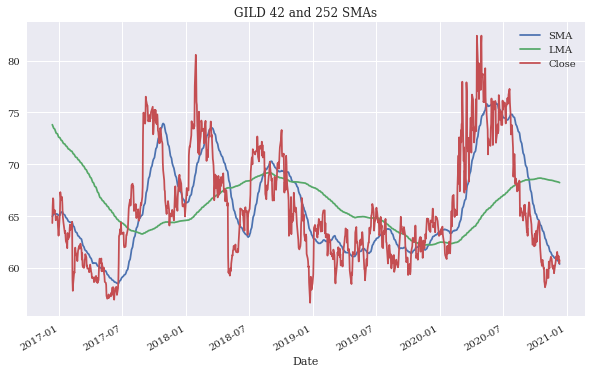

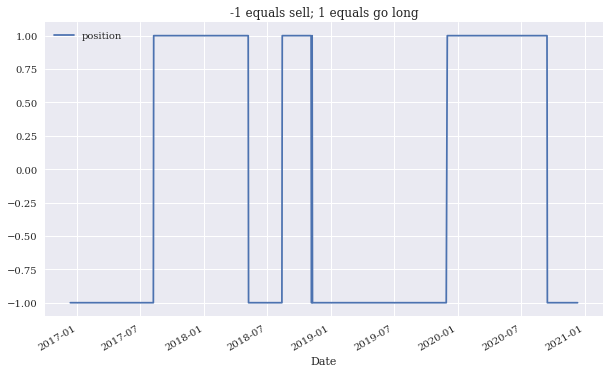

In [68]:
plot_sma('GILD')

# Moving Average Strategy

Analyzing how Short term vs Long term moving averages compares to a buy and hold strategy

In [4]:
def sma_strat(ticker):
    df = fetch_data(ticker)
    df['returns'] = np.log(df['Close']/df['Close'].shift(1))
    df['strat'] = df['position'].shift(1) * df['returns']
    #df[['returns', 'strat']].cumsum().apply(np.exp).plot(figsize=(10,6), 
                                                         #title=f"{ticker}: Moving Average Strategy vs Buy and Hold")
    #return df[['returns', 'strat']].mean()*252
    rets = df['returns'].mean()*252
    strat = df['strat'].mean()*252
    return (rets, strat)

returns   -0.322486
strat      0.322486
dtype: float64

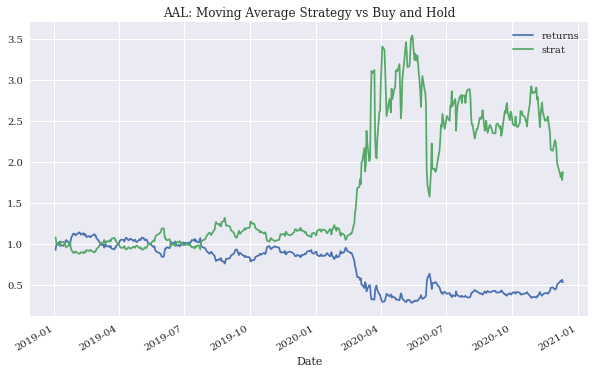

In [46]:
sma_strat('AAL', '2017-12-31')

# Systematically Assessing Effectiveness of MA Strategy

Testing Moving averages on every stock in the Nasdaq 100 to see whether moving averages are generally viable

In [5]:
web_data = requests.get('https://en.wikipedia.org/wiki/NASDAQ-100#Changes_in_2020').text
#Put data into Pandas to easily create a list of tickers to loop through
nasdaq_df = pd.read_html(web_data)
#Finds the Wiki table with tickers and stores them in Pandas Data Frame
nasdaq_df = nasdaq_df[3]
#Creates a list of tickers from Data Frame to loop through
nasdaq_tickers = list(nasdaq_df['Ticker'])

In [6]:
data = map(sma_strat, nasdaq_tickers)
df = pd.DataFrame(data, columns=['Returns', 'Strategy'], index=nasdaq_tickers)
df.head(10)
        

,Returns,Strategy
ATVI,0.209555,0.041355
ADBE,0.377811,0.286986
AMD,0.537935,0.366596
ALXN,0.012512,-0.253304
ALGN,0.409984,-0.177692
GOOGL,0.196947,0.054085
GOOG,0.203766,0.067369
AMZN,0.353091,0.198057
AMGN,0.139779,-0.055669
ADI,0.186020,-0.078180


In [7]:
df['Assessment'] = np.where(df['Strategy'] > df['Returns'], 'Outperforms', 'Does not Outperform')
df['Assessment'].value_counts()

Does not Outperform    92
Outperforms            11
Name: Assessment, dtype: int64

In [15]:
df['Returns'].median()

0.21089693581470403

# Looking at why SMA Outperform in Some Cases

In [16]:
df.query("Assessment== 'Outperforms'")


,Returns,Strategy,Assessment
BIDU,-0.010992,-0.002566,Outperforms
EA,0.130830,0.218217,Outperforms
INCY,-0.053950,-0.018358,Outperforms
JD,0.287760,0.388256,Outperforms
KHC,-0.181766,0.161130,Outperforms
LULU,0.399703,0.404163,Outperforms
MRNA,2.081484,2.133089,Outperforms
NTES,0.194446,0.201536,Outperforms
NVDA,0.443401,0.496363,Outperforms
TCOM,-0.064321,-0.061370,Outperforms


In [17]:
out_df = df.query("Assessment== 'Outperforms'")
out_df.reset_index(inplace=True)
out_ticks = list(out_df['index'])

In [22]:
yf_ticks = yf.Tickers(out_ticks)
data = yf_ticks.history('5y')


[*********************100%***********************]  11 of 11 completed


Text(0.5, 1.0, 'JD Price')

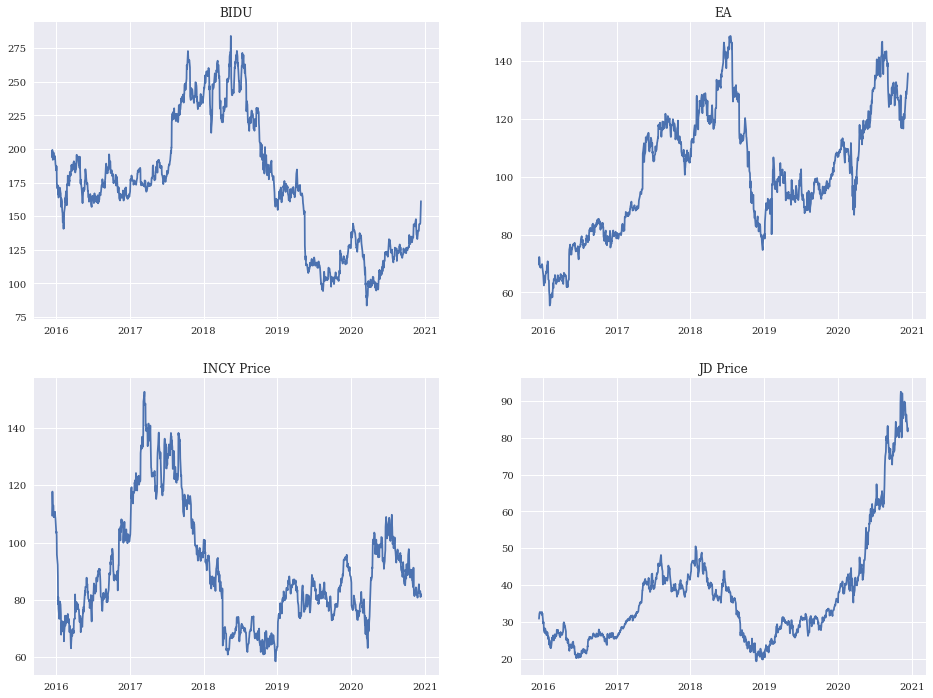

In [63]:
fig, axs = plt.subplots(2,2,figsize=(16,12))
axs[0,0].plot(data['Close']['BIDU'])
axs[0,0].set_title('BIDU')

axs[0,1].plot(data['Close']['EA'])
axs[0,1].set_title('EA')

axs[1,0].plot(data['Close']['INCY'])
axs[1,0].set_title('INCY Price')

axs[1,1].plot(data['Close']['JD'])
axs[1,1].set_title('JD Price')



Text(0.5, 1.0, 'NTES Price')

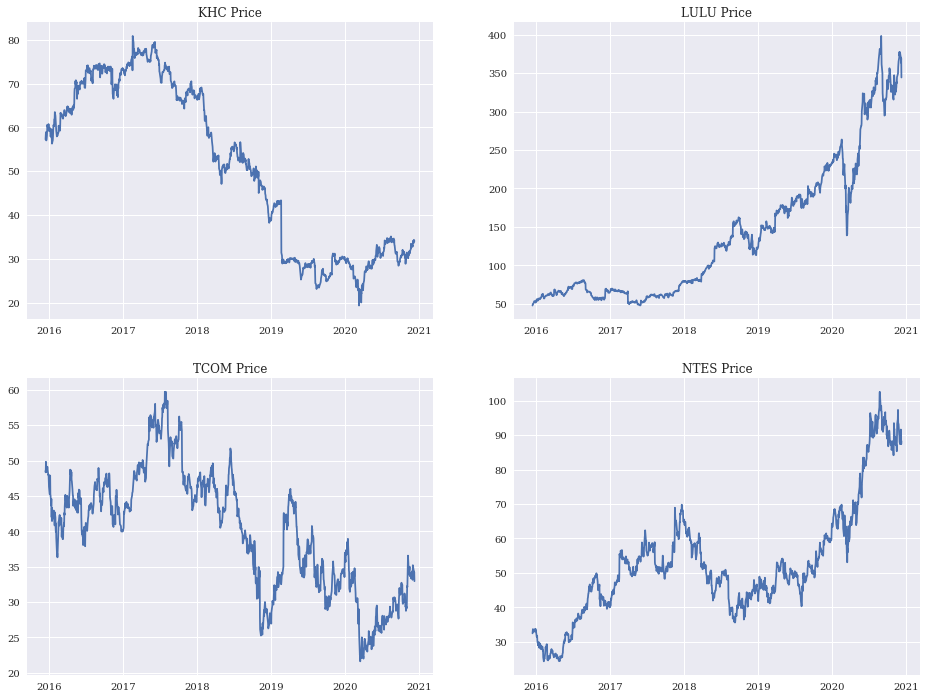

In [65]:
fig, axs = plt.subplots(2,2,figsize=(16,12))

axs[0,0].plot(data['Close']['KHC'])
axs[0,0].set_title('KHC Price')

axs[0,1].plot(data['Close']['LULU'])
axs[0,1].set_title('LULU Price')

axs[1,0].plot(data['Close']['TCOM'])
axs[1,0].set_title('TCOM Price')

axs[1,1].plot(data['Close']['NTES'])
axs[1,1].set_title('NTES Price')